# ЗАДАЧА ДЛЯ САМОСТОЯТЕЛЬНОГО ПРОЕКТА

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

## ЗАДАНИЯ ДЛЯ ПРОЕКТА

Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

- Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

- Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
Пример: train_df.spx.rolling(window=2).mean().

- Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

- С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

- Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

- Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

- Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
- Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
- Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
Сделайте выводы по полученным результатам.

In [340]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from arch import arch_model
import pmdarima as pm
import numpy as np

Прочтем файл:

In [341]:
data = pd.read_csv(
    "/Users/egor/Documents/data_science_course/SKILLFACTORY/MATH&ML-13. Временные ряды. Часть II/data/ghana_gdp.csv", 
    parse_dates=["year"], 
    index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Визуализируем временной ряд:

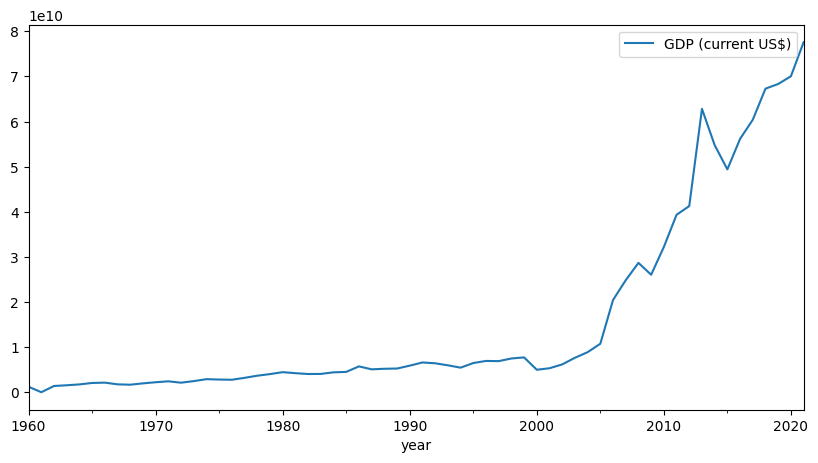

In [342]:
data.plot()
plt.show()

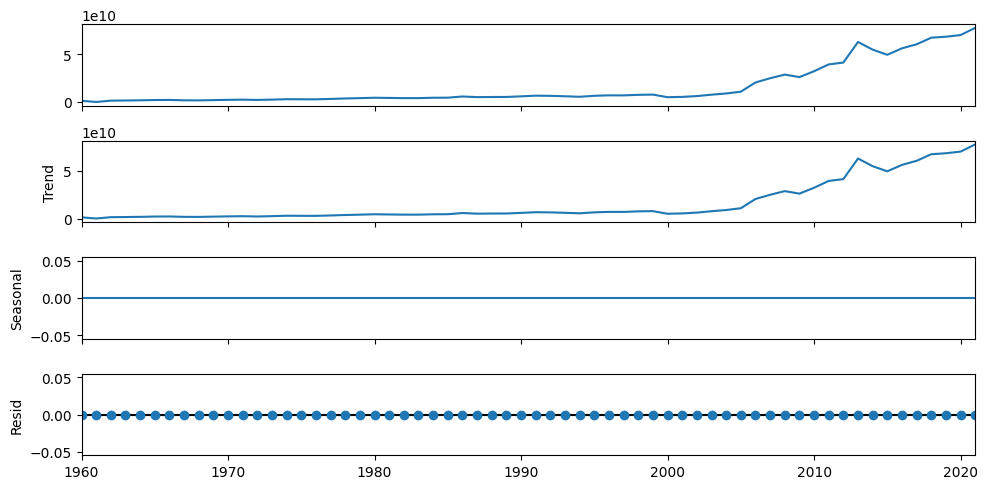

In [343]:
decomposition = seasonal_decompose(data)
decomposition.plot()
plt.show()

**Краткий вывод**:
*Заметим, что есть ярко выраженный тренд, а сезонность отсутствует. Остатки при этом сосредоточены около нуля.*

Разделим выбрку на тестовую и тренировочную:

In [344]:
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]
test_df

,GDP (current US$)
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


Построим модель скользящего среднего. Будем использовать среднее как функцию сглаживания. Построим графики с шириной окна в 2 года и 5 лет соответственно.

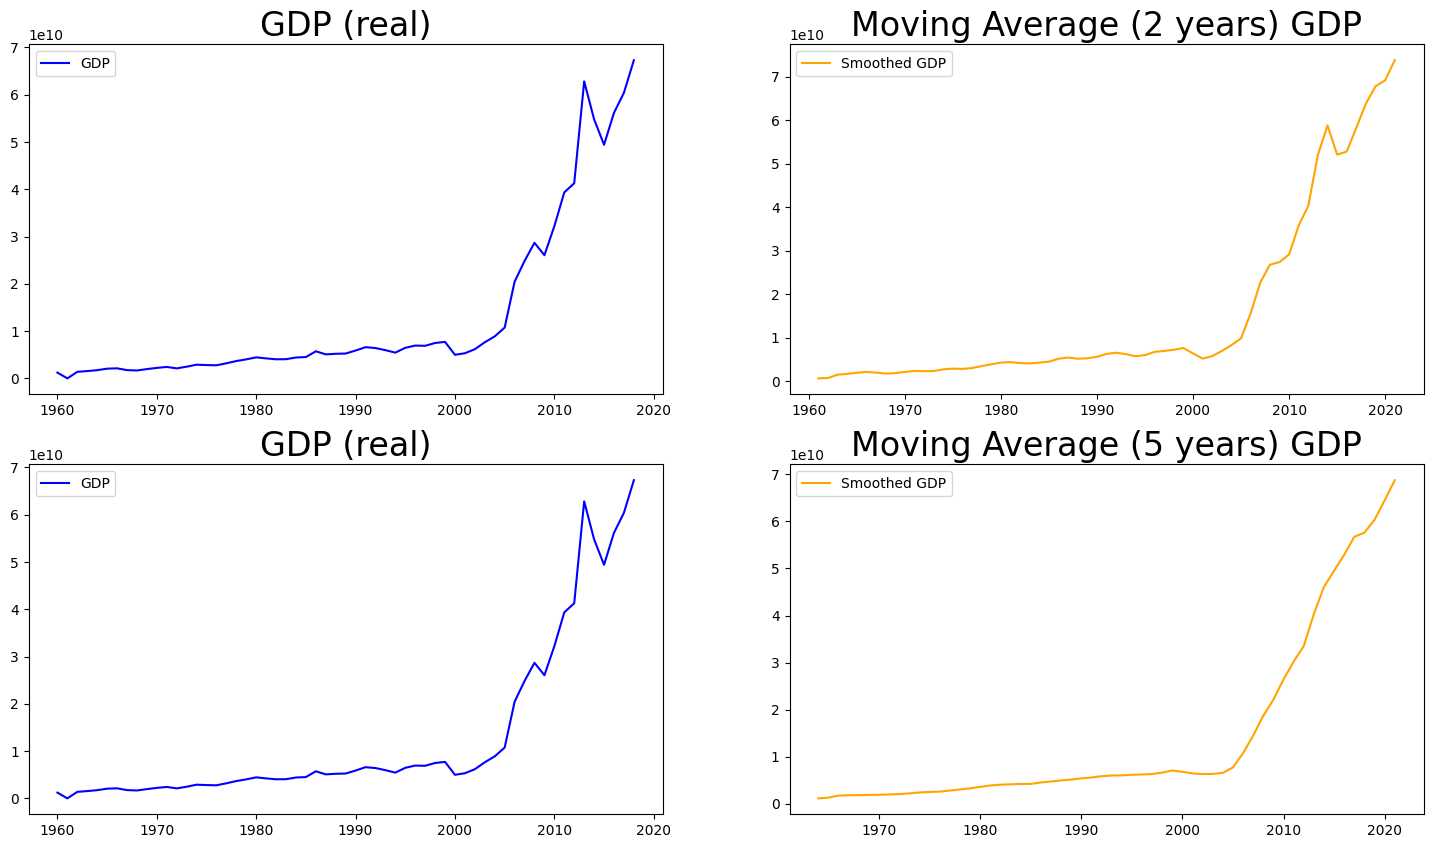

In [345]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)


ax[0, 0].plot(train_df, color="blue", label="GDP")
ax[0, 0].set_title("GDP (real)", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    data.rolling(window=2).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[0, 1].set_title("Moving Average (2 years) GDP", size=24)
ax[0, 1].legend()



ax[1, 0].plot(train_df, color="blue", label="GDP")
ax[1, 0].set_title("GDP (real)", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    data.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1, 1].set_title("Moving Average (5 years) GDP", size=24)
ax[1, 1].legend()

plt.show()

**Краткий вывод**:
*Модель МА с окном в 5 лет очень сильно сгладила график и мы потреряли часть данных, например скачок в 2013-2015. Модель МА с окном в 2 сгладила данные более аккуратно сохранив скачок.*

Оценим стационарность рядя с помощью функции stat_test и теста Дики-Фуллера:

In [346]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(data)

adf:  2.3738393561489173
p-value:  0.9989974617734
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
есть единичные корни, ряд не стационарен


Ряд нестационарен. Будем проводить дифференциацию до получения стационарного ряда.

In [347]:
data_1diff = data.diff().dropna()
data_2diff = data_1diff.diff().dropna()
data_3diff = data_2diff.diff().dropna()
stat_test(data_3diff)

adf:  -5.278476343687453
p-value:  6.066691711555503e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


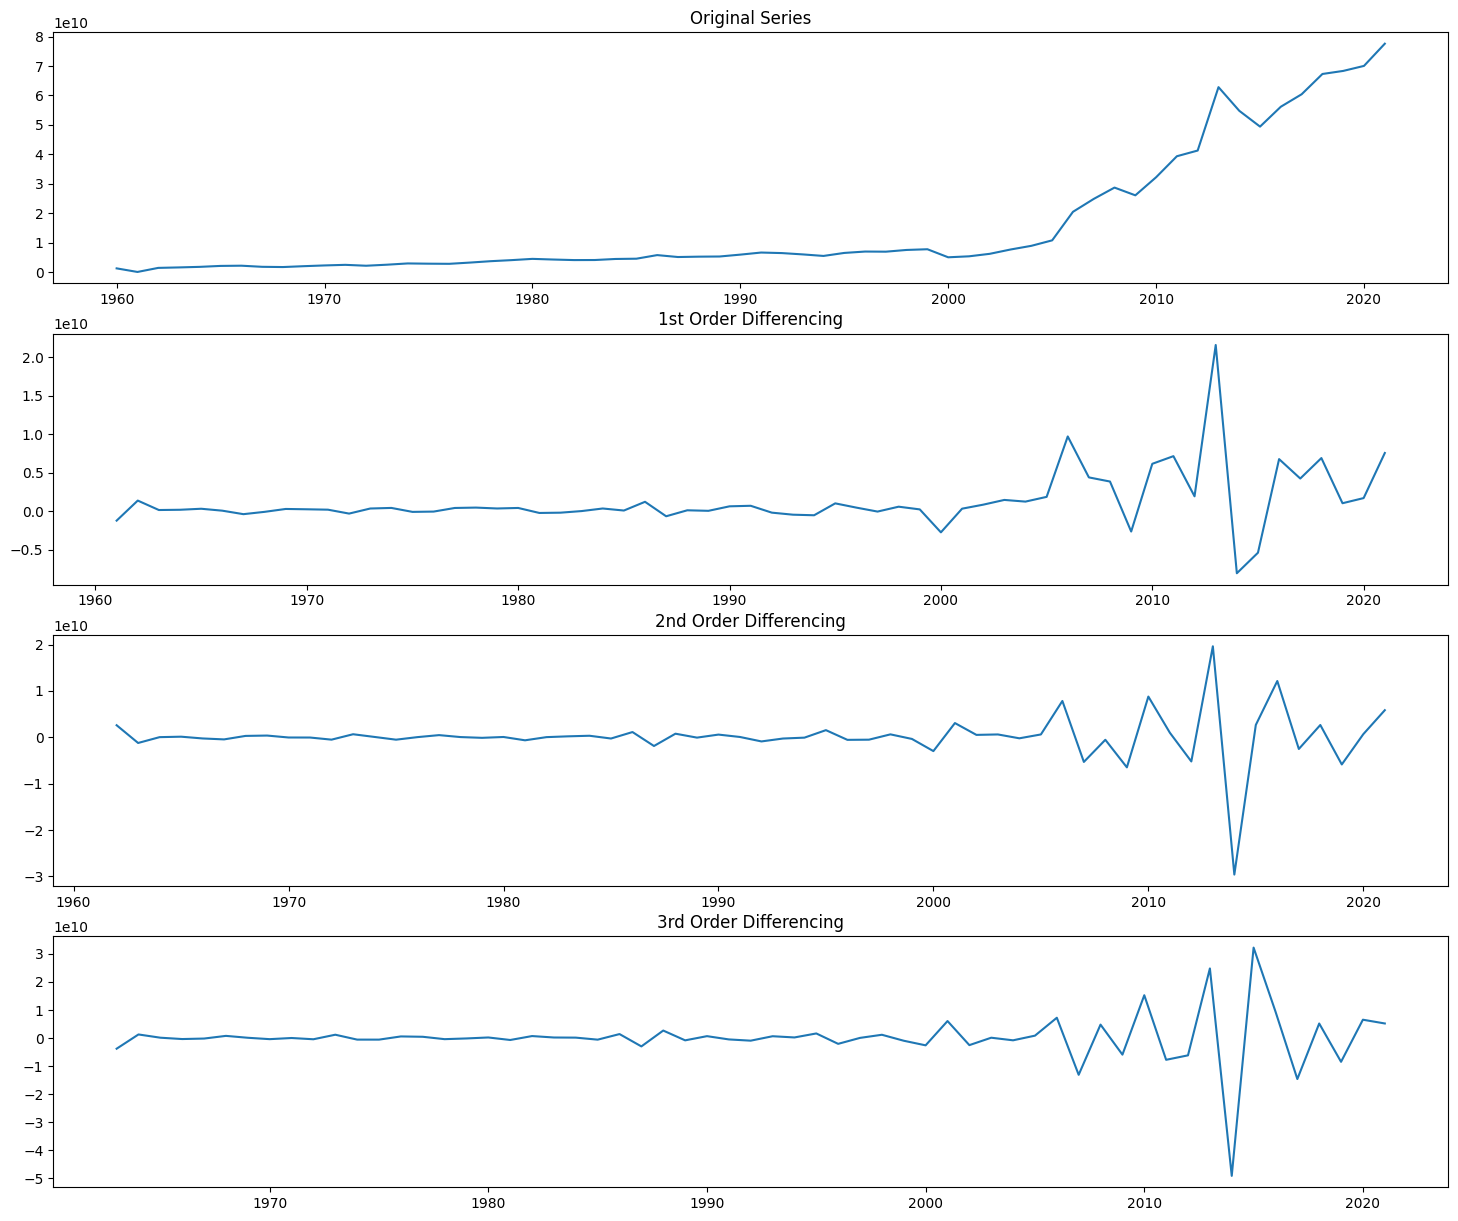

In [348]:
plt.rcParams["figure.figsize"] = 18, 15
# Original Series
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
ax1.plot(data); ax1.set_title('Original Series')
# 1st Differencing
ax2.plot(data_1diff); ax2.set_title('1st Order Differencing')
# 2nd Differencing
ax3.plot(data_2diff); ax3.set_title('2nd Order Differencing')
# 3nd Differencing
ax4.plot(data_3diff); ax4.set_title('3rd Order Differencing')
plt.show()

Ряд стал стационарным на третьем уровне дифференцирования. В этом случае мы будем использовать модель ARIMA с параметром d=3.

Теперь, для определения параметров p и q построим коррелограммы ACF и PACF.

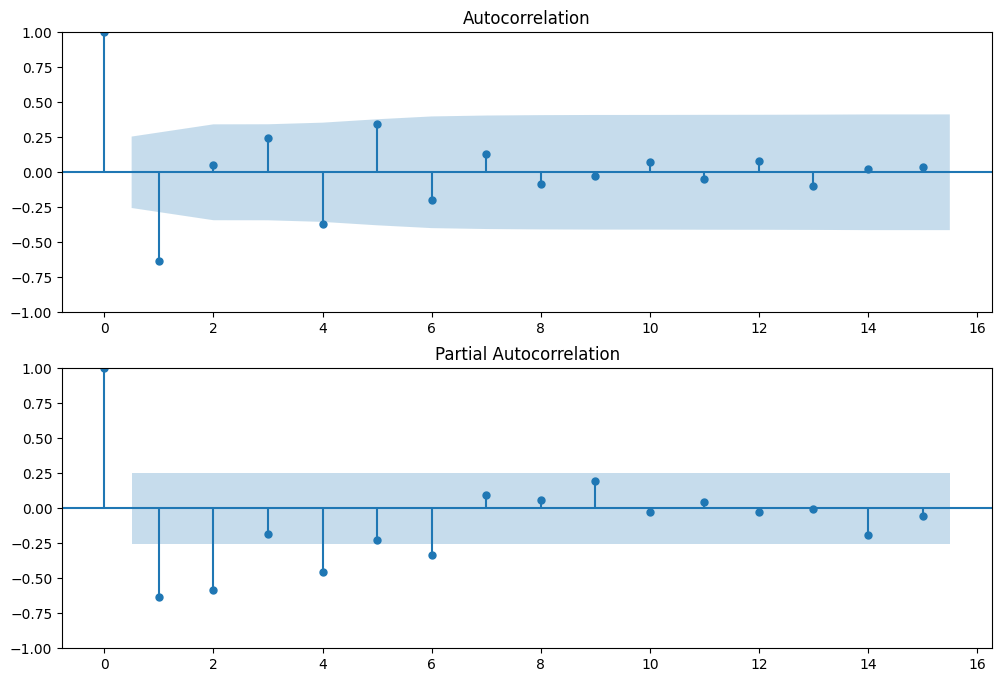

In [349]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_3diff.values.squeeze(), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_3diff, lags=15, ax=ax2)

Так как наибольшая корреляция по графикам (помимо нулевого лага) достигается на первом лаге, то принимаем p=1 и q=1

Построим модель ARIMA с найденными параметрами (p=1, d=3, q=1):

In [350]:
arima_model = ARIMA(train_df, order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Sun, 23 Jul 2023   AIC                           2670.910
Time:                        18:13:20   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+56. Standard errors may be unstable.
"""

При таких параметрах мы получили значение AIC=2670.910. Теперт воспользуемся pmdarima для подбора друших параметров, которые возможно покажут лучшую метрику.

In [351]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=15,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.01 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.01 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.213 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 23 Jul 2023   AIC                           2659.231
Time:                        18:13:20   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+56. Standard errors may be unstable.
"""

Auto.arima определила лучшие параметры p/d/q=(2,3,1). AIC=2659.231 в этом случае. Теперь построим новую модель по этим параметрам.

In [352]:
arima_model_2 = ARIMA(train_df, order=(2, 3, 1))
arima_model_fit_2 = arima_model_2.fit()
arima_model_fit_2.summary()

/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 23 Jul 2023   AIC                           2659.231
Time:                        18:13:20   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+56. Standard errors may be unstable.
"""

Создаем датафрейм с предсказаниями:

In [353]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit_2.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data['GDP (current US$)']

forecast = arima_model_fit_2.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

Ртрьпажаем на графике получившийся результат совместно с истинными данными и доверительным интервалом.

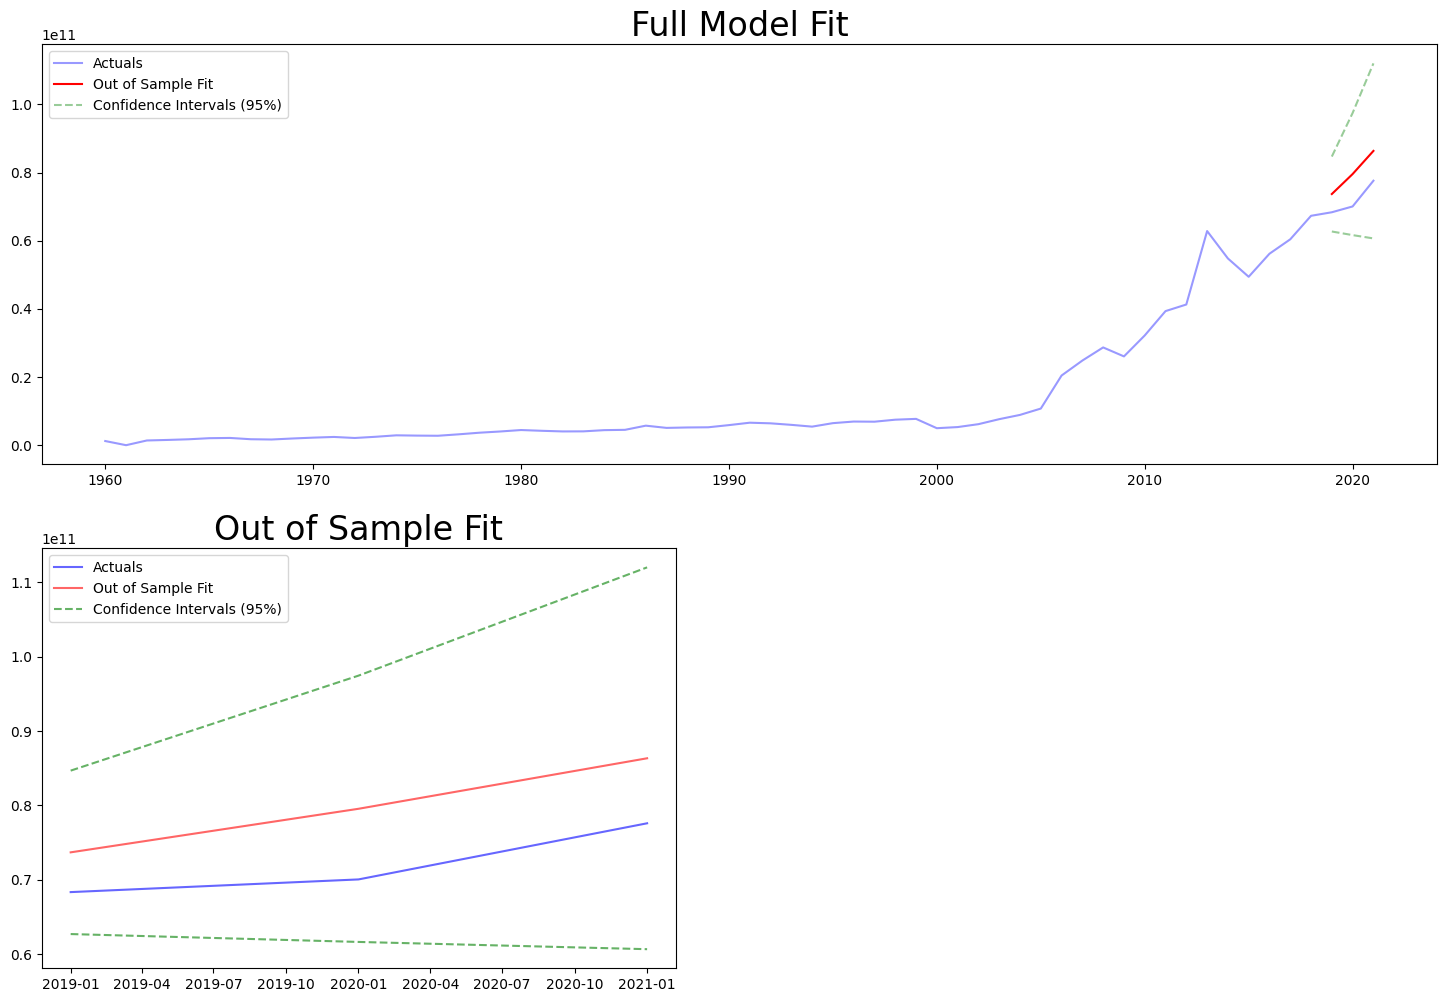

In [354]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

**Краткий вывод**:
*Модель ARIMA показала неплохой результат: тренд совпал с истинным, однако значения несколько превысили реальные.*

## ЗАДАНИЯ ДЛЯ ПРОЕКТА

- Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.

- Проверьте данные на наличие пропущенных значений (Series.isna().sum()).
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. 

- Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

- Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.
Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

Проверим данные на наличие пропущенных дат с помощью метода DataFrame.asfreq() (параметр частоты указываем начало каждого года, то есть 'YS')

In [355]:
data_m = data.asfreq(freq='YS')
data_m.isna().sum()

GDP (current US$)    0
dtype: int64

Нулевые значения также преобразуем в np.nan

In [356]:
data_m['GDP (current US$)'] = data_m['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

Теперь, для заполнения пропусков выполним интерполяцию:

In [357]:
data_m['GDP (current US$)'] = data_m['GDP (current US$)'].interpolate(method='linear')
data_m

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Проверим данные на стационарность:

In [358]:
stat_test(data_m)

adf:  2.3808487575556314
p-value:  0.99900101016983
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
есть единичные корни, ряд не стационарен


Ряд нестационарен. Будем проводить дифференциацию до получения стационарного ряда.

In [359]:
data_m_1diff = data_m.diff().dropna()
data_m_2diff = data_m_1diff.diff().dropna()
data_m_3diff = data_m_2diff.diff().dropna()
stat_test(data_m_3diff)

adf:  -5.456208629828492
p-value:  2.5783244972037654e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


Разделим выборки:

In [360]:
test_df = data_m.iloc[-3:]
train_df = data_m.iloc[:-3]
test_df

,GDP (current US$)
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


Определим визуально параметры модели: p и q.

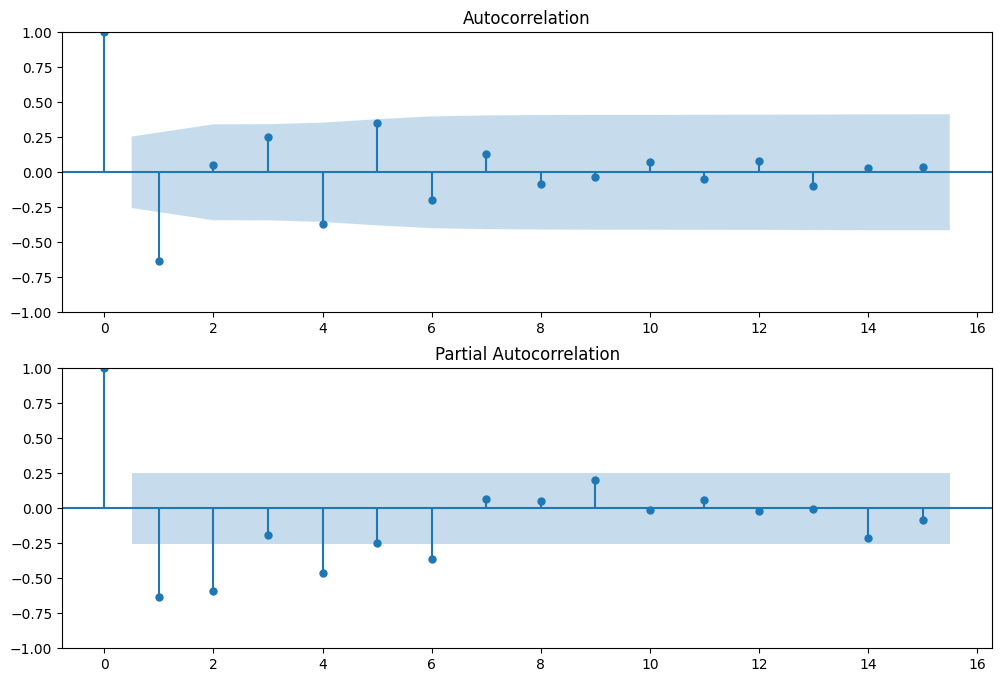

In [361]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_m_3diff.values.squeeze(), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_m_3diff, lags=15, ax=ax2)

Кажется p=1 и q=1 подойдут лучше всего. Но проверим себя с помощью auto.arima:


In [362]:
smodel_m = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=15,
    max_q=15,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel_m.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.01 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.00 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.181 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 23 Jul 2023   AIC                           2659.226
Time:                        18:13:21   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+57. Standard errors may be unstable.
"""

Auto.arima определила лучшие параметры p/d/q=(2,3,1). Параметры оказались теми же, что и до интерполяции, однако AIC незначительно улучшился с 2659.231 до 2659.226 в этом случае. Построим модель:

In [363]:
arima_model_3 = ARIMA(train_df, order=(2, 3, 1))
arima_model_fit_3 = arima_model_3.fit()
arima_model_fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 23 Jul 2023   AIC                           2659.226
Time:                        18:13:21   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+57. Standard errors may be unstable.
"""

Создаем датафрейм с предсказаниями:

In [364]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit_3.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data['GDP (current US$)']

forecast = arima_model_fit_3.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

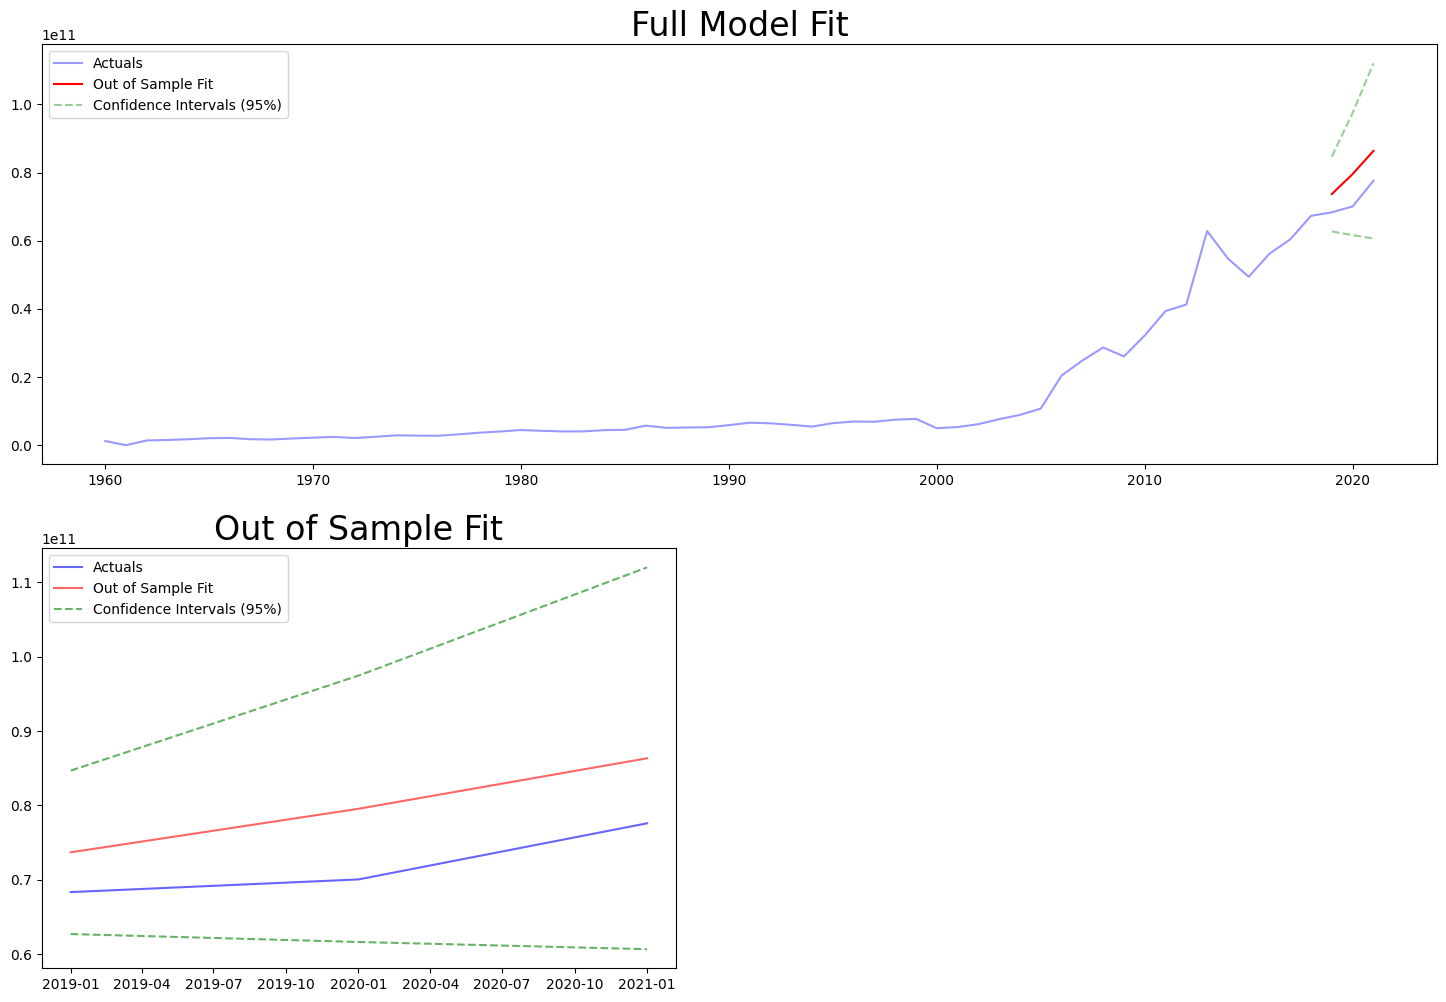

In [365]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

**Краткий вывод**:
*Заполнение отсутствующих данных с помощью интерполяции положительно сказалось на качестве модели. Появившиеся данные, хоть и незначительно, но улучшили метрику AIC.*

### Задача
- Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.
- Выведите размеры полученных подвыборок

In [366]:
tscv = TimeSeriesSplit(n_splits=3, test_size=3)
train_test_groups = tscv.split(data_m) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 53 TEST size: 3
TRAIN size: 56 TEST size: 3
TRAIN size: 59 TEST size: 3


### ЗАДАНИЯ ДЛЯ ПРОЕКТА

Посчитайте волатильность для вашего временного ряда.
Используйте GARCH-модель для предсказания волатильности.
Используйте линейную регрессию для получения прогноза.
Визуализируйте полученное предсказание вместе с фактическим значением.
Сравните результаты и сделайте выводы.
Почему результат модели GARCH получился именно таким?

Посчитаем волатильность для нашего ряда:

In [367]:
data_m['vol'] = data_m.pct_change(1).mul(100).abs()
data_m['vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: AS-JAN, Name: vol, dtype: float64

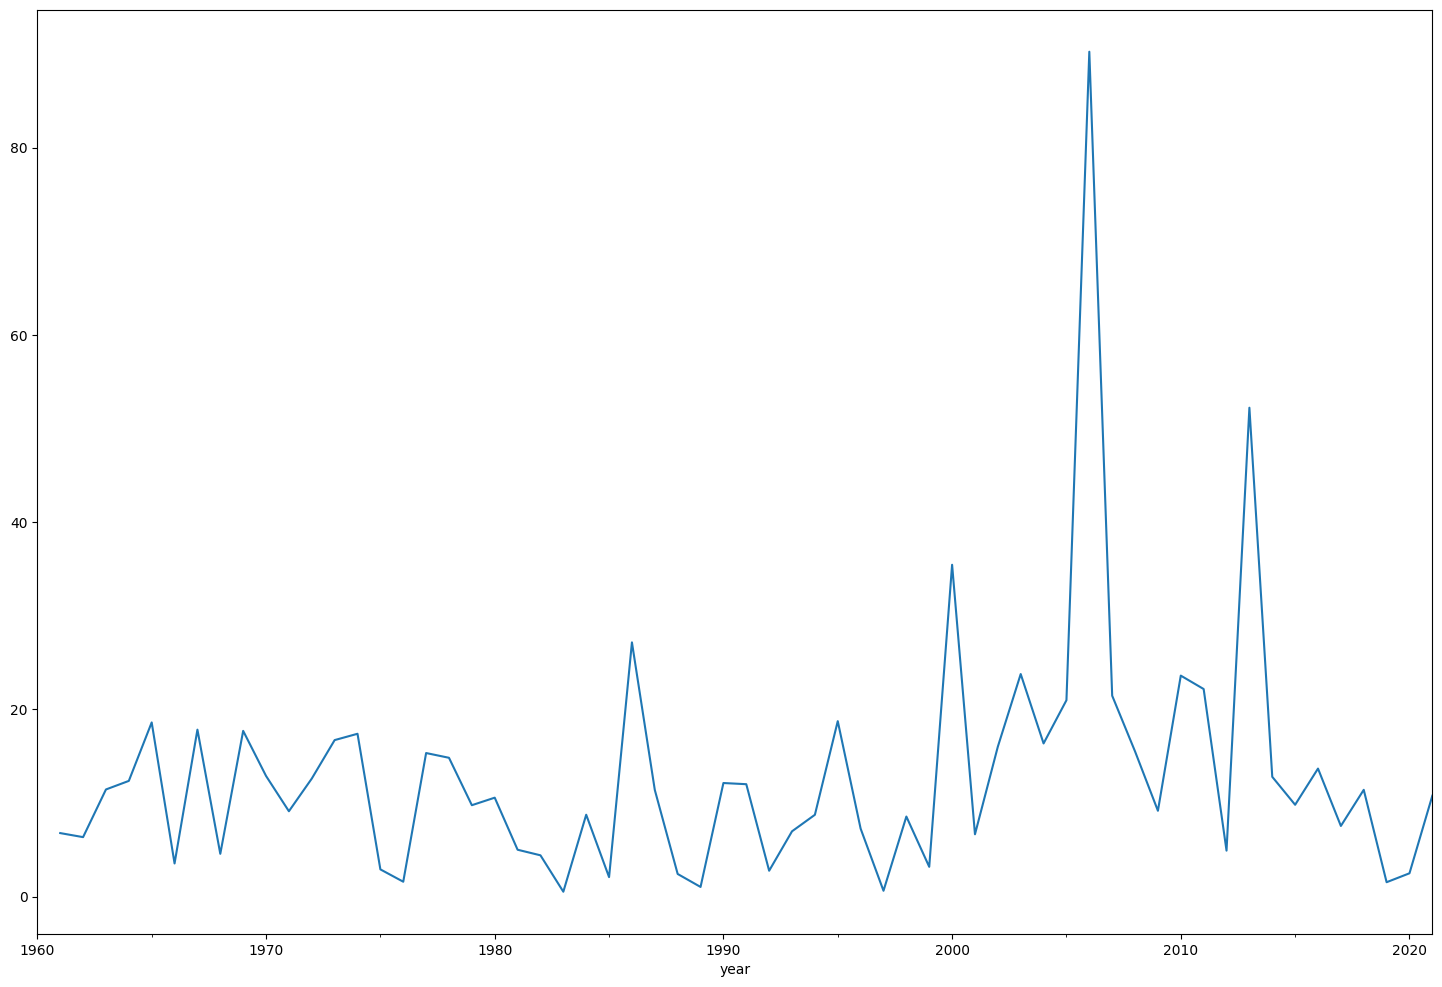

In [368]:
data_m['vol'].plot()
plt.show()

Разделим данные на тренировочную и тестовую выборку.

In [369]:
test_df = data_m.iloc[-3:]
train_df = data_m.iloc[:-3]
test_df

,GDP (current US$),vol
year,,
2019-01-01,6.833754e+10,1.542746
2020-01-01,7.004320e+10,2.495937
2021-01-01,7.759428e+10,10.780603


Оценим стационарность данных по волатильности:

In [370]:
adfuller(train_df.vol[1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [371]:
data_m.vol

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
                ...    
2017-01-01     7.551317
2018-01-01    11.410877
2019-01-01     1.542746
2020-01-01     2.495937
2021-01-01    10.780603
Freq: AS-JAN, Name: vol, Length: 62, dtype: float64

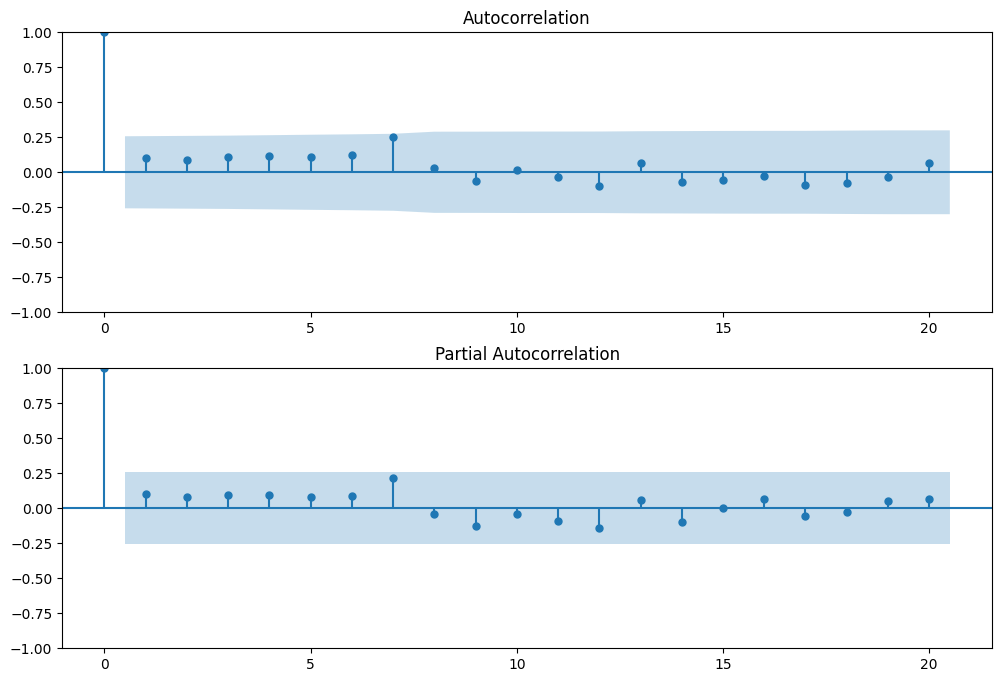

In [372]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.vol[1:].values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.vol[1:], lags=20, ax=ax2)

Глядя на графики ACF и PACF для волатильности, мы не можем явно определить самый значительный лаг. В таком случае выьерем параметры p и q равными единице. Итак, мы построим модель GARCH(1, 1).

In [373]:
garch_df = pd.DataFrame(data_m["vol"].loc[data_m.index])
garch_df.loc[train_df.index, "vol"] = train_df["vol"].dropna()

model = arch_model(garch_df["vol"].dropna(), p=1, q=1, vol='GARCH')

model_results = model.fit(last_obs=test_df.index[0], update_freq=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.97558663387127
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551638369347
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253904080169
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.15380118266583
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18833254549992
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.8822693931105
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.38715470810223
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.42725299165636
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.32430864349817
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4075.976317688216
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.9739633588884
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.91698146169185
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.81332686010794
Iteration:     14,   Func. Count:     83,   Neg. LLF: 2

In [374]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Sun, Jul 23 2023   Df Residuals:                       57
Time:                        18:13:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3192      2.572      4.790  1.670e-06 [  7.278, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6701     24.741      0.148      0.882 [-44.821, 52.161]
alpha[1]       0.0000  9.202e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.728e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

Создадим датасет с предсказаниями:

In [375]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]
predictions_df

/Users/egor/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,GDP (current US$),vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,288.548296
2020-01-01,7.004320e+10,2.495937,292.218352
2021-01-01,7.759428e+10,10.780603,295.888409


Визуализируем прогноз и реальные данные:

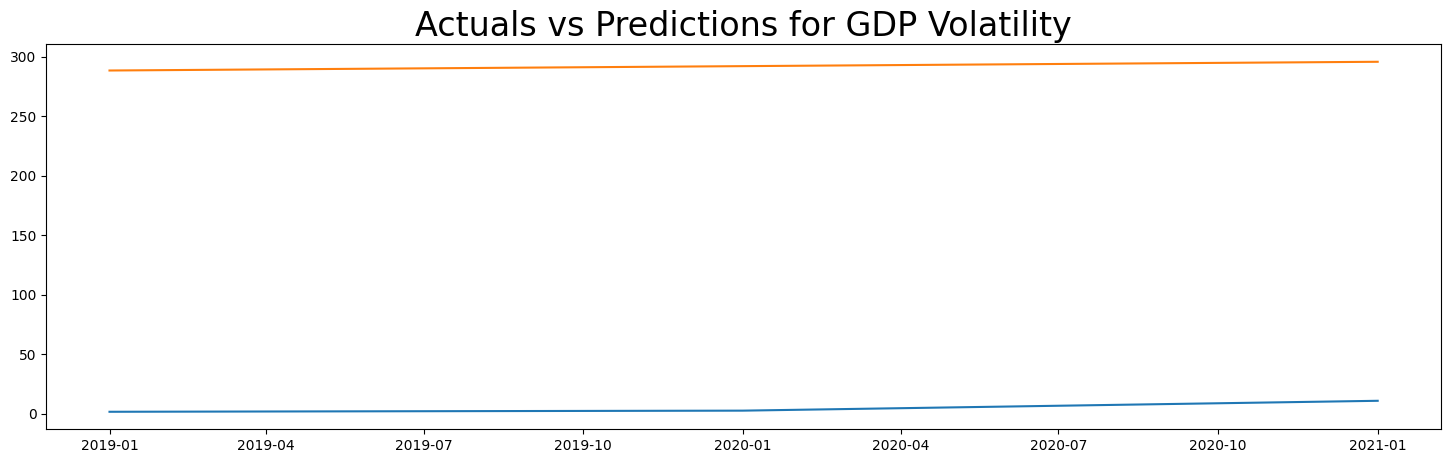

In [376]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

Модель сильно ошиблась в предсказании. Зафиксируем значение среднеквадратичной ошибки.

In [377]:
mean_squared_error(
    predictions_df["vol"].abs(), predictions_df["Predictions"]
)

82532.57469459453

Попробуем использовать модель линейной регрессии в этом случае: 

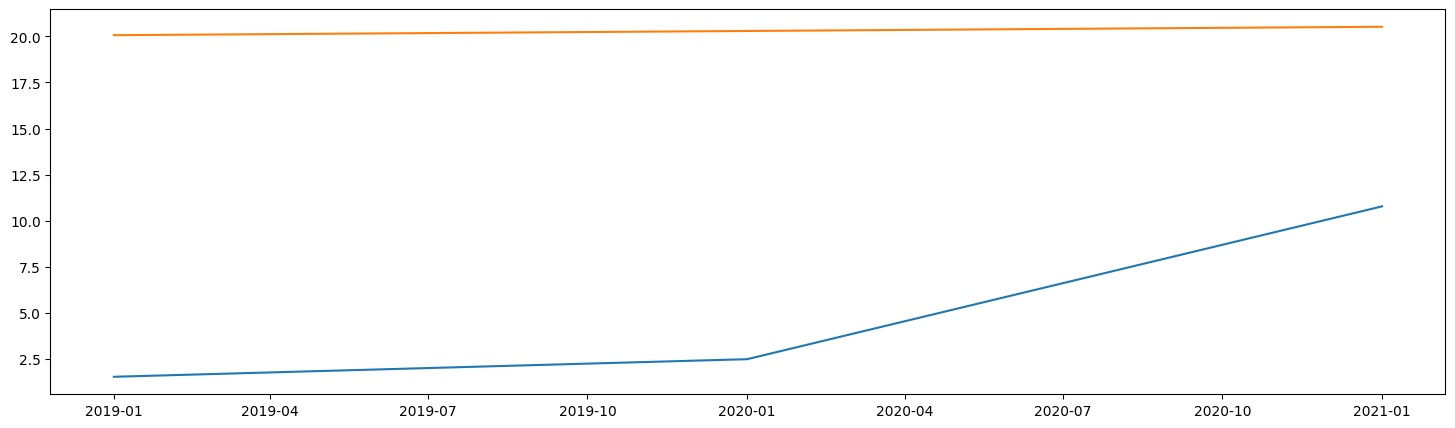

In [378]:
X_train = pd.DataFrame(range(data_m["vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data_m["vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["vol"].fillna(0)
y_test = test_df["vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Визуализируем все результаты на одном графике:

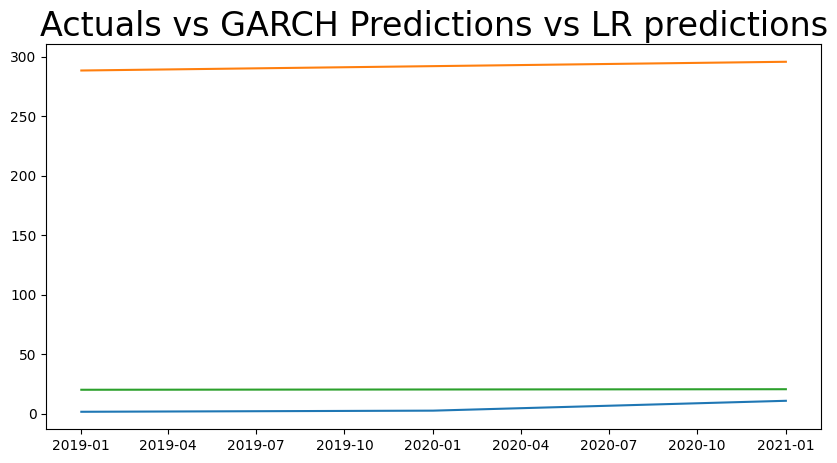

In [379]:
plt.rcParams["figure.figsize"] = 10, 5

plt.plot(predictions_df["vol"])
plt.plot(predictions_df["Predictions"])
plt.plot(pd.Series(lr_predict, index=y_test.index))

plt.title("Actuals vs GARCH Predictions vs LR predictions", size=24)

plt.show()

In [380]:
mean_squared_error(
    predictions_df["vol"].abs(), pd.Series(lr_predict, index=y_test.index)
)

251.408937764713

**Краткий вывод**:
*Проанализировав волатильность временного ряда с ВВП и построив GARCH модель мы получили неудовлетворительный результат, так как модель совсем не уловила дисперсию. Удивительным оказалось, что простая модель линейной регрессии показала значительно лучший результат: MAE для GARCH составила 82532, а для линейной регрессии - 251. Возможно, что причиной такого плохого результата у GARCH модели стало малое количество данных.*